In [90]:
#*************************************************************************************************************************
# Name: Jonah Zembower
# Date: 5/11/2024
# Final Project for Mathematical Modeling Course: Analysis of Epidemic Spread Using Mathematical and Computational Models
#*************************************************************************************************************************

# Importing Necessary Libraries:

In [91]:
# importing necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import random
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Bidirectional
from sklearn.model_selection import TimeSeriesSplit
from scipy.integrate import solve_ivp
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Functions for future code:

In [92]:
# Define the SIR model differential equations
def sir_model(t, y, beta, gamma):
    S, I, R = y
    N = S + I + R  # Total population
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - gamma * I
    dRdt = gamma * I
    return [dSdt, dIdt, dRdt]

In [93]:
def gillespie_sir(S0, I0, R0, beta, gamma, max_time):
    S, I, R = S0, I0, R0
    N = S + I + R
    t = 0
    times = [t]
    susceptible = [S]
    infected = [I]
    recovered = [R]

    while I > 0 and t < max_time:
        # Rates of infection and recovery
        infection_rate = beta * S * I / N
        recovery_rate = gamma * I
        total_rate = infection_rate + recovery_rate

        # Time until next event
        t += np.random.exponential(1 / total_rate)
        times.append(t)

        # Determine which event happens, infection or recovery
        if np.random.rand() < infection_rate / total_rate:
            S -= 1
            I += 1
        else:
            I -= 1
            R += 1

        # Record the state after the event
        susceptible.append(S)
        infected.append(I)
        recovered.append(R)

    return times, susceptible, infected, recovered


In [94]:
# SIR Model to test multiple gammas and betas
def sir_simulation(G, beta, gamma, initial_infected_rate, max_steps=100):
    # Initialize states
    susceptible = set(G.nodes())
    infected = set(random.sample(susceptible, int(initial_infected_rate * len(susceptible))))
    susceptible.difference_update(infected)
    recovered = set()
    
    record = [(len(susceptible), len(infected), len(recovered))]
    
    for _ in range(max_steps):
        if not infected:
            break
        
        new_infected = set()
        new_recovered = set()
        
        for node in infected:
            for neighbor in G.neighbors(node):
                if neighbor in susceptible and random.random() < beta:
                    new_infected.add(neighbor)
            if random.random() < gamma:
                new_recovered.add(node)
        
        infected.update(new_infected)
        susceptible.difference_update(new_infected)
        infected.difference_update(new_recovered)
        recovered.update(new_recovered)
        
        record.append((len(susceptible), len(infected), len(recovered)))
    
    return np.array(record)

In [95]:
def network_sir_simulation(G, beta, gamma, initial_infected_rate, max_steps=100):
    # Initialize statuses
    statuses = {node: 'S' for node in G.nodes()}  # S: Susceptible, I: Infected, R: Recovered
    initial_infected = random.sample(list(G.nodes()), int(initial_infected_rate * len(G.nodes())))
    for node in initial_infected:
        statuses[node] = 'I'
    
    # Record the number of S, I, R over time
    S, I, R = [len(G.nodes()) - len(initial_infected)], [len(initial_infected)], [0]
    time_steps = [0]

    current_step = 0
    while current_step < max_steps and I[-1] > 0:
        new_statuses = statuses.copy()
        for node in G.nodes():
            if statuses[node] == 'I':
                # Attempt to infect neighbors
                for neighbor in G.neighbors(node):
                    if statuses[neighbor] == 'S' and random.random() < beta:
                        new_statuses[neighbor] = 'I'
                # Recover
                if random.random() < gamma:
                    new_statuses[node] = 'R'
        
        statuses = new_statuses
        S.append(sum(1 for x in statuses.values() if x == 'S'))
        I.append(sum(1 for x in statuses.values() if x == 'I'))
        R.append(sum(1 for x in statuses.values() if x == 'R'))
        time_steps.append(current_step + 1)
        current_step += 1

    return time_steps, S, I, R


# Loading the Data:

In [96]:
# Load the datasets
disease_spread = pd.read_csv('/Users/jonahzembower/Library/CloudStorage/OneDrive-SetonHillUniversity/Semester Classwork/Spring 2024 Semester SHU/Mathematical Modeling/Projects/Final Project/Disease_Spread.csv')
population_network = pd.read_csv('/Users/jonahzembower/Library/CloudStorage/OneDrive-SetonHillUniversity/Semester Classwork/Spring 2024 Semester SHU/Mathematical Modeling/Projects/Final Project/Population_Contact_Network.csv')

# Display the first few rows of each dataset
disease_spread.head(), population_network.head()


(   Day  Susceptible  Infected  Recovered
 0    0          990        10          0
 1    1          987        12          1
 2    2          983        14          2
 3    3          979        17          4
 4    4          974        20          5,
    Person1  Person2
 0        0       41
 1        0      110
 2        0      272
 3        0      368
 4        0      490)

# Data Overview:

##### Disease Spread Dataset:
This dataset includes daily records with the following columns:
- Day: The day number in the simulation.
- Susceptible: The number of people who are susceptible to the infection.
- Infected: The number of currently infected individuals.
- Recovered: The number of individuals who have recovered from the infection.

##### Population Contact Network Dataset:
This dataset represents the social interactions among students, suitable for constructing a graph where:
- Person1 and Person2 are individuals, and each row represents a contact between them that could potentially lead to disease transmission.

# Preprocessing:

In [97]:
# Check for missing values in both datasets
missing_values_disease = disease_spread.isnull().sum()
missing_values_network = population_network.isnull().sum()

missing_values_disease, missing_values_network


(Day            0
 Susceptible    0
 Infected       0
 Recovered      0
 dtype: int64,
 Person1    0
 Person2    0
 dtype: int64)

Both datasets have no missing values, which is excellent news for the modeling process. We can move forward without needing to handle missing data.

Next, let's check for any anomalies or inconsistencies, such as negative numbers in the disease spread counts or duplicated edges in the network dataset that might affect the graph analysis. I'll check for:
- Negative values in the Susceptible, Infected, or Recovered counts.
- Duplicated rows in the population contact network, which might represent redundant interactions.

In [98]:
# Check for any negative values in the disease spread data
negative_values_disease = (disease_spread[['Susceptible', 'Infected', 'Recovered']] < 0).any()

# Check for duplicated rows in the population contact network
duplicate_rows_network = population_network.duplicated().sum()

negative_values_disease, duplicate_rows_network


(Susceptible    False
 Infected       False
 Recovered      False
 dtype: bool,
 0)

The checks indicate that there are no negative values in the Susceptible, Infected, or Recovered columns of the disease spread data. Additionally, there are no duplicate rows in the population contact network dataset. This suggests that the data are well-prepared for further analysis and modeling.

# Model the Spread of the Disease:

To model the spread of the SHU Flu using a system of differential equations, we'll start by setting up the Susceptible-Infected-Recovered (SIR) model. The SIR model describes the change over time in the number of people in each of these three categories. Here's a brief overview of the model:

- Susceptible (S): individuals who are susceptible to contracting the disease.
- Infected (I): individuals who have contracted the disease and can spread it to susceptible individuals.
- Recovered (R): individuals who have recovered from the disease and are assumed to be immune and no longer able to be infected again or spread the disease.

In [99]:
# Parameters (assumed)
beta = 0.3  # Infection rate, assumed based on standard practice
gamma = 1/10  # Recovery rate, assuming infectious period is 10 days

# Initial conditions
S0, I0, R0 = disease_spread.loc[0, ['Susceptible', 'Infected', 'Recovered']]

# Time span for the simulation: from day 0 to last day in the dataset
t_span = [0, disease_spread['Day'].iloc[-1]]
t_eval = np.arange(t_span[0], t_span[1] + 1)  # Evaluate solution at each day

# Solve the SIR model differential equations
result = solve_ivp(sir_model, t_span, [S0, I0, R0], args=(beta, gamma), t_eval=t_eval)

result.y[:3]  # Show only the first 3 results for brevity


array([[990.        , 986.72322902, 982.75173156, 977.94808151,
        972.15077653, 965.17430637, 956.80933042, 946.83824238,
        934.9904836 , 920.96790695, 904.49932569, 885.34065032,
        863.27488858, 838.11905641, 809.79122285, 778.31086123,
        743.83159022, 706.64860886, 667.19869658, 626.0602132 ,
        583.95309892, 541.73887431, 500.32280182, 460.25919749,
        422.0033355 , 385.92661573, 352.31107222, 321.34937321,
        293.14482113, 267.7113526 , 244.97353843, 224.76895687,
        206.86908573, 191.00099804, 176.91404375, 164.38897381,
        153.23794022, 143.30449597, 134.46359513, 126.62159277,
        119.71624498, 113.65305561, 108.25592482, 103.44480132,
         99.14970479,  95.3078299 ,  91.86354626,  88.76839846,
         85.98110608,  83.46756365,  81.20084067,  79.15925451,
         77.3080653 ,  75.62821165,  74.10638585,  72.7296322 ,
         71.48534698,  70.36127852,  69.34552711,  68.42654508,
         67.59313674,  66.83445842,  66.

Trying other betas and gammas as well:

/var/folders/5v/l60713ps6gz1y72cj6ls8g_w0000gn/T/ipykernel_3842/1060232565.py:5: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  infected = set(random.sample(susceptible, int(initial_infected_rate * len(susceptible))))
/var/folders/5v/l60713ps6gz1y72cj6ls8g_w0000gn/T/ipykernel_3842/1060232565.py:5: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  infected = set(random.sample(susceptible, int(initial_infected_rate * len(susceptible))))
/var/folders/5v/l60713ps6gz1y72cj6ls8g_w0000gn/T/ipykernel_3842/1060232565.py:5: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  infected = set(random.sample(susceptible, int(initial_infected_rate * len(susceptible))))
/var/folders/5v/l60713ps6gz1y72cj6ls8g_w0000gn/T/ipykernel_3842/1060232565.py:5: DeprecationWarning: Sampling from a set deprecated
since Pyth

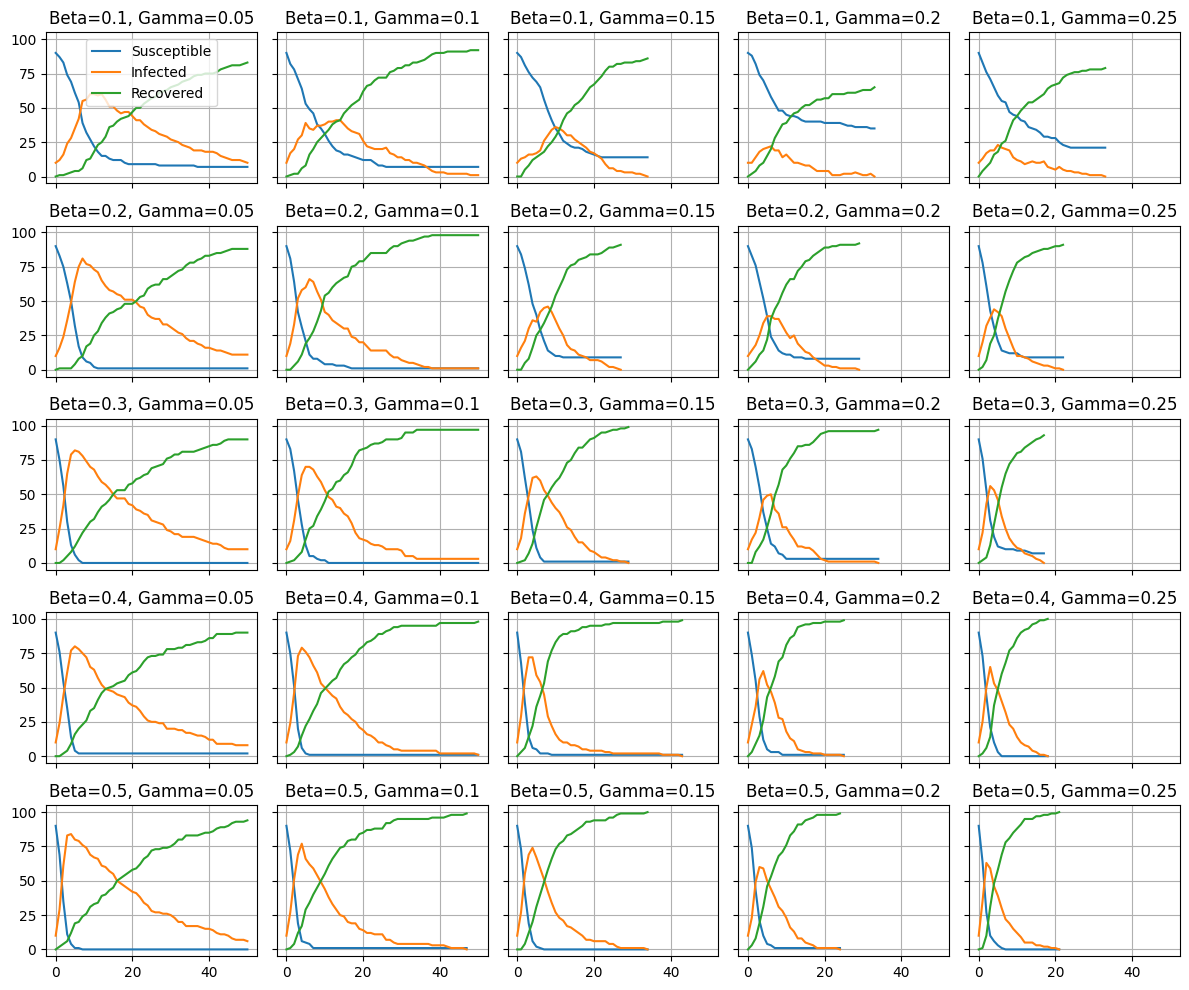

In [100]:
# Setup parameters
betas = [0.1, 0.2, 0.3, 0.4, 0.5]
gammas = [0.05, 0.1, 0.15, 0.2, 0.25]
initial_infected_rate = 0.1

# Create a test network
test_network = nx.erdos_renyi_graph(100, 0.05)

# Plotting
fig, axes = plt.subplots(len(betas), len(gammas), figsize=(12, 10), sharex=True, sharey=True)

for i, beta in enumerate(betas):
    for j, gamma in enumerate(gammas):
        results = sir_simulation(test_network, beta, gamma, initial_infected_rate, 50)
        ax = axes[i][j]
        ax.plot(results[:, 0], label='Susceptible')
        ax.plot(results[:, 1], label='Infected')
        ax.plot(results[:, 2], label='Recovered')
        ax.set_title(f'Beta={beta}, Gamma={gamma}')
        ax.grid(True)

axes[0,0].legend()
plt.tight_layout()
plt.show()

Analysis by Rows (Varying β with Constant γ)
- First Row (β=0.1): As γ increases from left to right, the peak of infected individuals decreases and occurs earlier. Faster recovery rates lead to shorter durations of infection.
- Second Row (β=0.2): With a higher β, the infected peak is higher than in the first row, showing more intense outbreaks. Again, higher γ values flatten the curve somewhat and accelerate recovery.
- Third Row (β=0.3): The infection spreads more aggressively due to the further increase in β. The pattern of quicker and more extensive recovery with higher γ holds.
- Fourth Row (β=0.4) and Fifth Row (β=0.5): These rows show very rapid spreads of infection with large portions of the population getting infected quickly. Higher γ rates still help in quicker recoveries but the impact of high β values is significant, resulting in sharp and high peaks of infection.

Analysis by Columns (Varying γ with Constant β)
- First Column (γ=0.05): Across all β values, slow recovery rates result in longer-lasting outbreaks with a gradual increase in recovered individuals.
- Second to Fifth Columns (γ increasing from 0.1 to 0.25): As γ increases, the recovery phase is faster, reducing the number of currently infected individuals more quickly and increasing the recovered count.

Key Observations:
- Key Observations:
- Higher β Values: Lead to quicker and broader spreads of the infection, overwhelming susceptible populations more rapidly.
- Higher γ Values: Effectively reduce the duration of the infection, leading to faster recoveries and lowering the peak of active infections.
- Control Strategies: In real-world scenarios, increasing γ (e.g., through effective medical interventions) can significantly help manage outbreaks, especially when β is high. Conversely, reducing β through preventive measures (e.g., social distancing, lockdowns) is crucial in delaying and flattening the infection peak.

This matrix provides valuable insights for public health planning, showing the importance of balancing between reducing transmission rates and enhancing recovery rates to manage epidemic outbreaks effectively.

#### Visualizing Optimal SIR Model Results:
Let's visualize the results of this simulation to see how the epidemic evolves over time according to our model. This will help us compare the model's behavior under these parameters with the actual data, if needed. I can plot the counts of Susceptible, Infected, and Recovered individuals over time. I am plotting using the initial β = 0.3 and γ = 0.1.

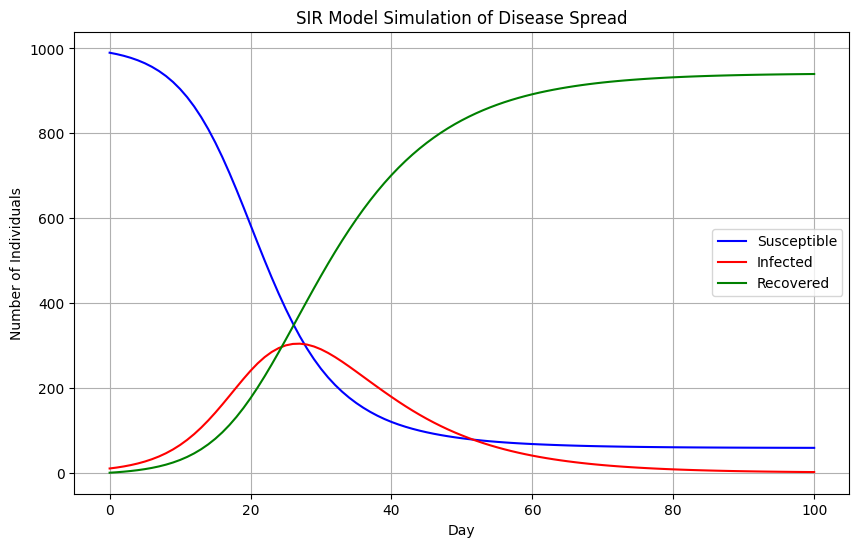

In [101]:
# Extract the simulation results
S, I, R = result.y

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(t_eval, S, label='Susceptible', color='blue')
plt.plot(t_eval, I, label='Infected', color='red')
plt.plot(t_eval, R, label='Recovered', color='green')
plt.title('SIR Model Simulation of Disease Spread')
plt.xlabel('Day')
plt.ylabel('Number of Individuals')
plt.legend()
plt.grid(True)
plt.show()


Here's the plot of the SIR model simulation, showing the progression of the Susceptible, Infected, and Recovered groups over time. As seen in the graph:

- The number of Susceptible individuals decreases over time as more people get infected.
- The number of Infected individuals initially increases, reaches a peak, and then declines as individuals recover or become immune.
- The Recovered count increases steadily, representing people who recover from the infection and are no longer susceptible.

#### Adjustments and Analysis
This model gives us a basic understanding of the epidemic's dynamics under the assumed parameters. We can adjust the parameters (𝛽 and γ) to better fit any actual data, or to explore different scenarios (e.g., increased transmission rate, slower recovery). We can also integrate stochastic elements or consider public health interventions like vaccination or social distancing to see how they might alter the epidemic curve as well.

# Stochastic Modeling:

Introducing stochastic elements into the SIR model can make it more realistic by accounting for the random nature of disease transmission and recovery. A common approach to stochastic modeling in epidemiology is to use the Gillespie algorithm, which is a discrete-event simulation method. It accounts for the inherent randomness in the timing and order of events, such as infections and recoveries.

##### Stochastic SIR Model:
In the stochastic version of the SIR model, the transition probabilities for the next event depend on the current state of the system. Here's how it generally works:
- Infection event: A susceptible individual becomes infected. The rate at which this happens is proportional to both the number of susceptible individuals and the number of infectious contacts, which is a function of the number of currently infected individuals and the infection rate (𝛽).
- Recovery event: An infected individual recovers. This happens at a rate proportional to the number of infected individuals and the recovery rate (γ).

##### Gillespie Algorithm Outline:
- Initialize the state of the system (numbers of susceptible, infected, and recovered individuals).
- Calculate the rates of infection and recovery events:
  - Infection rate: β×S×I/N
  - Recovery rate: γ×I
- Determine the time to the next event using an exponential distribution based on the total rate of events (sum of infection and recovery rates).
- Choose the type of the next event (infection or recovery) based on their relative probabilities.
- Update the state of the system (adjust counts of S, I, and R).
- Record the time and state, and repeat until no more infections can occur or a maximum time is reached.

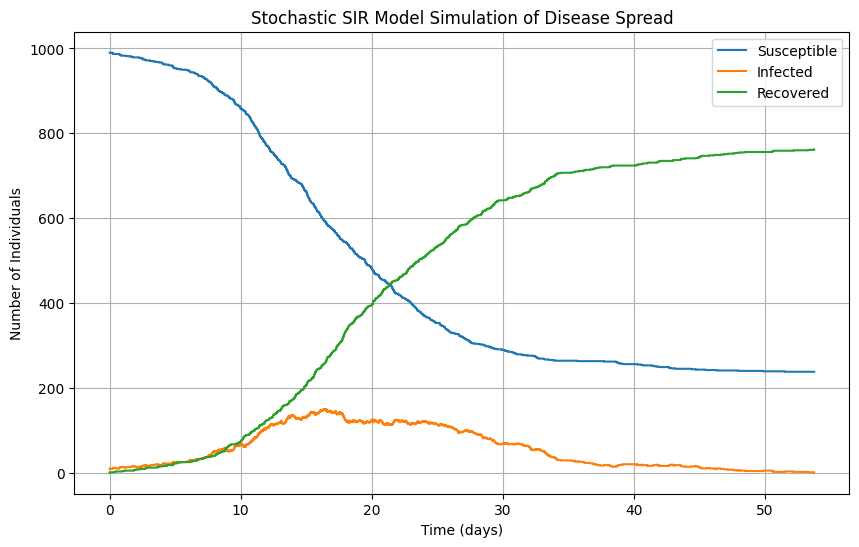

In [102]:
# Using the same initial conditions and parameters
stochastic_results = gillespie_sir(S0, I0, R0, beta, gamma, max_time=100)  # Simulate for 100 days

# Plotting the stochastic SIR results
plt.figure(figsize=(10, 6))
plt.step(stochastic_results[0], stochastic_results[1], label='Susceptible', where='post')
plt.step(stochastic_results[0], stochastic_results[2], label='Infected', where='post')
plt.step(stochastic_results[0], stochastic_results[3], label='Recovered', where='post')
plt.title('Stochastic SIR Model Simulation of Disease Spread')
plt.xlabel('Time (days)')
plt.ylabel('Number of Individuals')
plt.legend()
plt.grid(True)
plt.show()


The plot shows the results of the stochastic SIR model simulation. This model includes randomness in the timing and order of infection and recovery events, which provides a more nuanced understanding of how disease spread might fluctuate due to stochastic factors in a real-world setting.

##### Key Observations:
- Infected Curve: Notice the jagged nature of the Infected curve, which reflects the random occurrence of infection and recovery events. This is different from the smoother curve in the deterministic model and is a realistic depiction of how actual disease outbreaks can unpredictably rise and fall.
- Variability: The times at which the number of infections peak and then decline can vary significantly in each simulation run due to the inherent randomness.
- Duration: The overall duration of the epidemic can vary. The stochastic model can sometimes show quicker resolutions or unexpectedly prolonged outbreaks, depending on the sequence of events.

This stochastic approach is particularly useful for exploring scenarios under different intervention strategies or in smaller populations where random fluctuations have a more pronounced effect.

# Neural Network Predictions:

Epoch 1/50


14/14 [==============================] - 1s 11ms/step - loss: 0.2109 - val_loss: 0.2217
Epoch 2/50
14/14 [==============================] - 0s 3ms/step - loss: 0.1097 - val_loss: 0.1785
Epoch 3/50
14/14 [==============================] - 0s 3ms/step - loss: 0.0357 - val_loss: 0.1937
Epoch 4/50
14/14 [==============================] - 0s 3ms/step - loss: 0.0172 - val_loss: 0.2197
Epoch 5/50
14/14 [==============================] - 0s 3ms/step - loss: 0.0171 - val_loss: 0.2271
Epoch 6/50
14/14 [==============================] - 0s 3ms/step - loss: 0.0137 - val_loss: 0.1875
Epoch 7/50
14/14 [==============================] - 0s 3ms/step - loss: 0.0150 - val_loss: 0.1334
Epoch 8/50
14/14 [==============================] - 0s 3ms/step - loss: 0.0117 - val_loss: 0.1445
Epoch 9/50
14/14 [==============================] - 0s 3ms/step - loss: 0.0103 - val_loss: 0.1101
Epoch 10/50
14/14 [==============================] - 0s 3ms/step - loss: 0.0084 - val_loss: 0.0943
Epoch 11/50
14/14 [==========

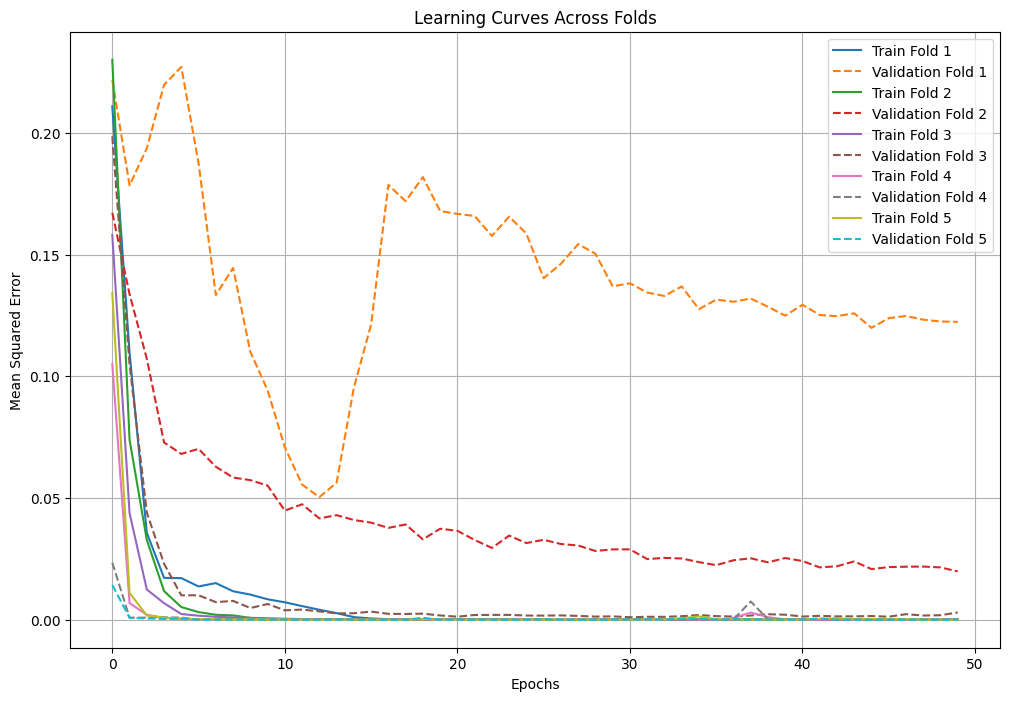

In [103]:
# Data loading and preprocessing
data = np.array(disease_spread[['Susceptible', 'Infected', 'Recovered']])
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

# Parameters
sequence_length = 7
input_shape = (sequence_length, 3)  # 3 features: Susceptible, Infected, Recovered
n_splits = 5

# Prepare TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=n_splits)
fold = 0
histories = []

for train_index, test_index in tscv.split(data_scaled):
    X_train, X_test = data_scaled[train_index], data_scaled[test_index]
    y_train, y_test = data_scaled[train_index], data_scaled[test_index]
    
    # Create generators
    train_generator = TimeseriesGenerator(X_train, y_train, length=sequence_length, batch_size=1)
    test_generator = TimeseriesGenerator(X_test, y_test, length=sequence_length, batch_size=1)
    
    # Model definition
    model = Sequential([
        LSTM(50, activation='relu', input_shape=input_shape),
        Dense(3)
    ])
    model.compile(optimizer='adam', loss='mse')
    
    # Fit model
    history = model.fit(train_generator, validation_data=test_generator, epochs=50)
    histories.append(history)
    
    # Increment fold number
    fold += 1

# Plotting learning curves
plt.figure(figsize=(12, 8))
for i, history in enumerate(histories):
    plt.plot(history.history['loss'], label=f'Train Fold {i+1}')
    plt.plot(history.history['val_loss'], label=f'Validation Fold {i+1}', linestyle='--')

plt.title('Learning Curves Across Folds')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.grid(True)
plt.show()


- Analysis of Learning Curves:
  - The learning curves show the Mean Squared Error (MSE) for training and validation across five different folds of the dataset.
  - Training Curves (solid lines): In all folds, the training error rapidly decreases in the initial epochs, suggesting that the model quickly learns from the training data. After the initial rapid decrease, the training error tends to plateau, which is typical as the model starts to converge.
  - Validation Curves (dashed lines): The validation error trends are more varied across the folds. In some folds, validation error decreases along with training error, which is ideal. However, in other folds (particularly noticeable in folds 1 and 5), the validation error shows significant volatility and spikes. This could indicate overfitting, where the model learns the specifics of the training data too well but fails to generalize effectively to unseen data.
- Key Observations:
  - Overfitting Indicators: The spikes and increases in validation MSE in certain folds, coupled with lower corresponding training MSE, clearly suggest overfitting.
  - Generalization Issue: The disparity between training and validation performance in several folds highlights potential issues in the model's ability to generalize. This might be due to the complexity of the model or the nature of the data splits.

Epoch 1/100
78/78 [==============================] - 1s 4ms/step - loss: 0.1384 - val_loss: 0.0347
Epoch 2/100
78/78 [==============================] - 0s 3ms/step - loss: 0.0418 - val_loss: 0.0049
Epoch 3/100
78/78 [==============================] - 0s 3ms/step - loss: 0.0310 - val_loss: 0.0075
Epoch 4/100
78/78 [==============================] - 0s 2ms/step - loss: 0.0225 - val_loss: 0.0055
Epoch 5/100
78/78 [==============================] - 0s 3ms/step - loss: 0.0236 - val_loss: 0.0064
Epoch 6/100
78/78 [==============================] - 0s 2ms/step - loss: 0.0197 - val_loss: 0.0010
Epoch 7/100
78/78 [==============================] - 0s 2ms/step - loss: 0.0169 - val_loss: 0.0031
Epoch 8/100
78/78 [==============================] - 0s 2ms/step - loss: 0.0201 - val_loss: 0.0013
Epoch 9/100
78/78 [==============================] - 0s 3ms/step - loss: 0.0168 - val_loss: 9.1943e-04
Epoch 10/100
78/78 [==============================] - 0s 3ms/step - loss: 0.0160 - val_loss: 2.3330e-04
E

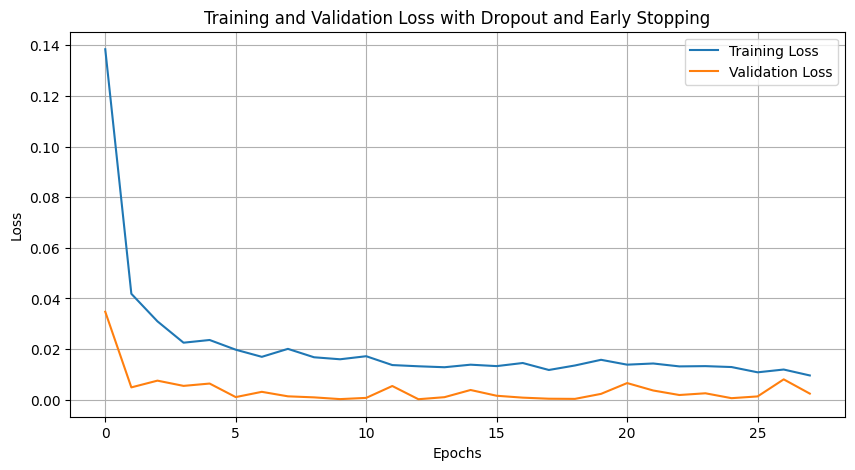

In [104]:
# Adjusting dropout and early stopping
model = Sequential([
    LSTM(50, activation='relu', input_shape=input_shape, return_sequences=True),
    Dropout(0.3),  # Increased dropout
    LSTM(50, activation='relu'),
    Dropout(0.3),  # Increased dropout
    Dense(3)
])

model.compile(optimizer='adam', loss='mse')
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)  # Adjusted patience

# Refitting the model
history = model.fit(train_generator, validation_data=test_generator, epochs=100, callbacks=[early_stopping])

# Plotting training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss with Dropout and Early Stopping')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

- Graph Analysis
  - Rapid Decrease in Early Epochs: Both training and validation losses show a sharp decrease in the initial epochs. This suggests that the model is effectively learning from the data, and significant learning occurs early in the training process.
  - Convergence and Stability: By around epoch 4, both losses level off and remain relatively stable and close to each other throughout the remaining epochs. This stability is a good indication that the model is not overfitting significantly, as the validation loss does not start to diverge or increase relative to the training loss.
  - Low Validation Loss: The validation loss remains low and close to the training loss, which implies that the model generalizes well to unseen data. The close tracking of validation loss with training loss suggests effective learning without memorizing the training data.

Epoch 1/20
78/78 [==============================] - 1s 4ms/step - loss: 0.0920 - val_loss: 0.0024
Epoch 2/20
78/78 [==============================] - 0s 2ms/step - loss: 0.0142 - val_loss: 0.0018
Epoch 3/20
78/78 [==============================] - 0s 2ms/step - loss: 0.0117 - val_loss: 0.0013
Epoch 4/20
78/78 [==============================] - 0s 2ms/step - loss: 0.0098 - val_loss: 0.0011
Epoch 5/20
78/78 [==============================] - 0s 2ms/step - loss: 0.0076 - val_loss: 0.0014
Epoch 6/20
78/78 [==============================] - 0s 2ms/step - loss: 0.0077 - val_loss: 1.7114e-04
Epoch 7/20
78/78 [==============================] - 0s 2ms/step - loss: 0.0068 - val_loss: 2.9079e-04
Epoch 8/20
78/78 [==============================] - 0s 2ms/step - loss: 0.0068 - val_loss: 0.0016
Epoch 9/20
78/78 [==============================] - 0s 2ms/step - loss: 0.0054 - val_loss: 2.3672e-04
Epoch 10/20
78/78 [==============================] - 0s 2ms/step - loss: 0.0057 - val_loss: 0.0020
Epoch 1

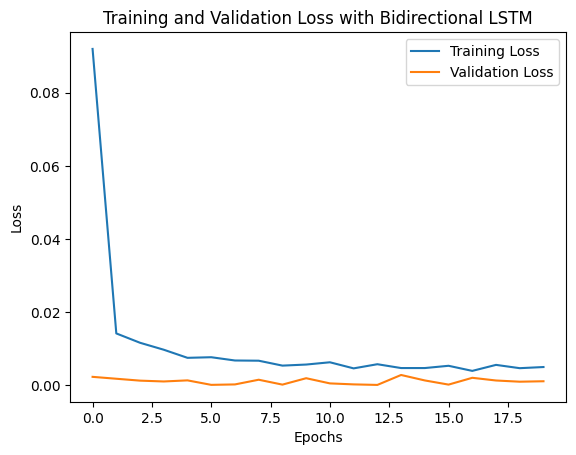

In [105]:
# Adjusting the model to include a Bidirectional LSTM
model = Sequential([
    Bidirectional(LSTM(50, activation='relu'), input_shape=input_shape),
    Dropout(0.2),
    Dense(3)
])

model.compile(optimizer='adam', loss='mse')
history = model.fit(train_generator, validation_data=test_generator, epochs=20)

# Plotting new training and validation losses
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss with Bidirectional LSTM')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


- Analysis of the Graph
  - Rapid Decrease in Loss: Both the training and validation losses drop sharply in the first few epochs, indicating that the model is quickly learning from the data.
  - Convergence and Low Loss: After the initial sharp decrease, both losses level off and remain very close to each other throughout the rest of the training period. This is a positive sign, suggesting that the model is not overfitting—validation loss is low and follows the training loss closely.
  - Stability: The losses are stable and low from about epoch 5 onwards, indicating that the model has learned a stable pattern from the data and is generalizing well to unseen data (validation set).
- I believe I found the optimal method, and I will now proceed with that method.

In [106]:
# Load the dataset
data = np.array(disease_spread[['Susceptible', 'Infected', 'Recovered']])
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

# Splitting the data into training, validation, and test sets
train_val_data, test_data = train_test_split(data_scaled, test_size=0.2, shuffle=False)
train_data, val_data = train_test_split(train_val_data, test_size=0.25, shuffle=False)  # 0.25 * 0.8 = 0.2

# Define sequence length and batch size
sequence_length = 7
batch_size = 1

# Create data generators
train_generator = TimeseriesGenerator(train_data, train_data, length=sequence_length, batch_size=batch_size)
val_generator = TimeseriesGenerator(val_data, val_data, length=sequence_length, batch_size=batch_size)
test_generator = TimeseriesGenerator(test_data, test_data, length=sequence_length, batch_size=batch_size)

# Define input shape for LSTM model
input_shape = (sequence_length, data_scaled.shape[1])  # data.shape[1] should be 3 (Susceptible, Infected, Recovered)


Epoch 1/50


53/53 [==============================] - 1s 4ms/step - loss: 0.1370 - val_loss: 0.0537
Epoch 2/50
53/53 [==============================] - 0s 2ms/step - loss: 0.0302 - val_loss: 0.0105
Epoch 3/50
53/53 [==============================] - 0s 2ms/step - loss: 0.0146 - val_loss: 0.0027
Epoch 4/50
53/53 [==============================] - 0s 2ms/step - loss: 0.0096 - val_loss: 0.0026
Epoch 5/50
53/53 [==============================] - 0s 2ms/step - loss: 0.0091 - val_loss: 0.0016
Epoch 6/50
53/53 [==============================] - 0s 2ms/step - loss: 0.0069 - val_loss: 7.3118e-04
Epoch 7/50
53/53 [==============================] - 0s 2ms/step - loss: 0.0079 - val_loss: 0.0023
Epoch 8/50
53/53 [==============================] - 0s 3ms/step - loss: 0.0085 - val_loss: 0.0016
Epoch 9/50
53/53 [==============================] - 0s 2ms/step - loss: 0.0085 - val_loss: 0.0028
Epoch 10/50
53/53 [==============================] - 0s 2ms/step - loss: 0.0079 - val_loss: 0.0040
Epoch 11/50
53/53 [=======

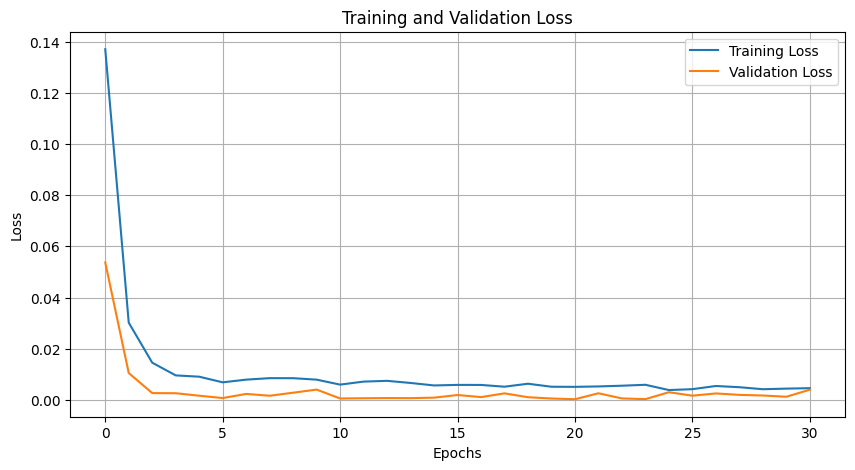

In [107]:
# Define the model with Bidirectional LSTM and Dropout
model = Sequential([
    Bidirectional(LSTM(50, activation='relu'), input_shape=input_shape),
    Dropout(0.2),
    Dense(3)
])

# Compile the model
model.compile(optimizer='adam', loss='mse')

# Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Fit the model
history = model.fit(train_generator, validation_data=val_generator, epochs=50, callbacks=[early_stopping])
# Plotting training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()



14/14 [==============================] - 0s 1ms/step


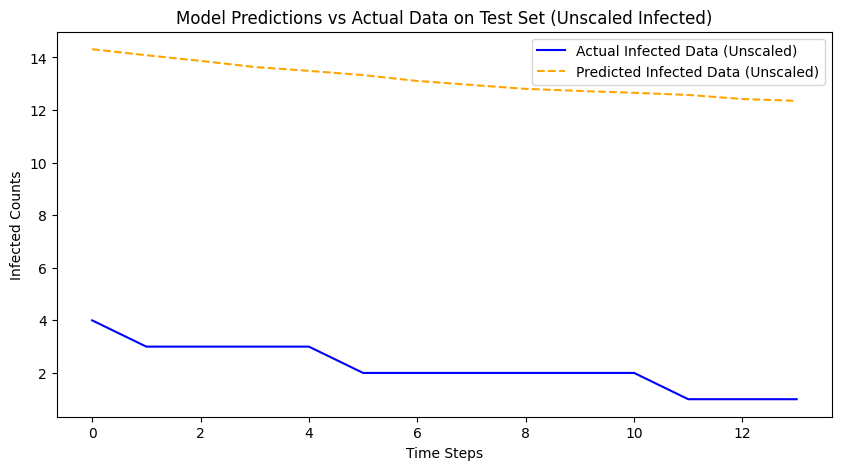

In [108]:
# Assuming predictions are 2D where each row corresponds to a prediction with 3 columns (Susceptible, Infected, Recovered)
predictions = model.predict(test_generator)
predictions_infected = predictions[:, 1]  # Extracting the 'Infected' data assuming it's the second column

# We need to extract the corresponding target values from the generator, which are often batched in sequences.
# We will take the last item of each sequence for each batch because the LSTM predicts the next step based on the sequence.
actuals_infected = np.array([batch[1][-1, 1] for batch in test_generator])  # Assuming 'Infected' is at index 1

# Reshape the data if necessary to fit the scaler's expected input
predictions_reshaped = predictions_infected.reshape(-1, 1)
actuals_reshaped = actuals_infected.reshape(-1, 1)

# Reconstruct the full array for predictions and actuals
full_predictions = np.zeros((predictions_reshaped.shape[0], 3))  # Create a zero array with three features
full_predictions[:, 1] = predictions_reshaped[:, 0]  # Assuming 'Infected' is the second feature

full_actuals = np.zeros((actuals_reshaped.shape[0], 3))
full_actuals[:, 1] = actuals_reshaped[:, 0]

# Inverse transform the full arrays
predictions_unscaled = scaler.inverse_transform(full_predictions)
actuals_unscaled = scaler.inverse_transform(full_actuals)

# Extract the Infected data for plotting
predictions_unscaled_infected = predictions_unscaled[:, 1]
actuals_unscaled_infected = actuals_unscaled[:, 1]

# Plotting the unscaled infected data
plt.figure(figsize=(10, 5))
plt.plot(actuals_unscaled_infected, label='Actual Infected Data (Unscaled)', color='blue')
plt.plot(predictions_unscaled_infected, label='Predicted Infected Data (Unscaled)', color='orange', linestyle='--')
plt.title('Model Predictions vs Actual Data on Test Set (Unscaled Infected)')
plt.xlabel('Time Steps')
plt.ylabel('Infected Counts')
plt.legend()
plt.show()


- Analysis of the Plot
  - Trend and Fit:
    - Predicted Infected Data (Unscaled): The predictions follow a generally declining trend, which seems to reflect a pattern or expectation that the model has learned from the training data. The dashed orange line shows that the model expects a gradual decrease in infected counts over the time steps.
    - Actual Infected Data (Unscaled): The actual data shows a stepwise decrease with periods of stability. This indicates specific times where the infection count remains constant before dropping further.
  - Model Performance:
    - The model seems to capture the overall downward trend in infection counts. However, it does not capture the stepwise nature of the actual data, instead predicting a more smooth and continuous decrease.
    - This might suggest that the model is generalizing the trend but missing finer nuances or abrupt changes in the data. It could be due to the nature of the LSTM which might smooth out some of the variability seen in actual data.
  - Accuracy and Error:
    - The model consistently overestimates the infected counts compared to actual data. This consistent overestimation can be quantified using metrics like MAE (Mean Absolute Error) and RMSE (Root Mean Squared Error) to better understand the magnitude and impact of these errors.

In [109]:
mse = mean_squared_error(actuals_unscaled_infected, predictions_unscaled_infected)
mae = mean_absolute_error(actuals_unscaled_infected, predictions_unscaled_infected)

print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)


Mean Squared Error: 120.01606414334957
Mean Absolute Error: 10.94920343000974


- Mean Squared Error (MSE): 
  - MSE is more sensitive to outliers than MAE because it squares the differences before averaging them, which increases the weight of larger errors. The MSE suggests that, on average, the squares of the prediction errors are relatively significant. This could indicate that there are substantial discrepancies between some of the predicted and actual values.
  - A higher MSE value can mean that the model might be fitting or predicting well on average or for the majority of the data but struggling significantly on some instances, potentially those with abrupt changes or anomalies as seen in the plot.
- Mean Absolute Error (MAE): 
  - MAE provides a straightforward interpretation of average error magnitude. The MAE suggests that, on average, the absolute differences between predicted and actual infected counts are about the value of MAE persons (assuming the count is in terms of number of persons, adjust accordingly if unit differs).
  - The relatively high MAE, in this case, also reflects the inaccuracies visible in the plot where the model predictions consistently overestimate the infected counts, not adapting well to the actual stepwise decreases.

Future Considerations for the model:
- Model Sensitivity to Changes: The high MSE relative to the MAE suggests some large errors are significantly influencing the average error squared. This could mean the model needs better handling of data points where there are significant changes in the infection count.
- Consistent Overestimation: The consistent overestimation suggests that the model might benefit from additional features or different modeling techniques that could help it adapt to rapid changes or declines in infected counts. This might involve looking at more granular data, incorporating external factors, or tweaking the model’s architecture.
- Potential Underfitting: Given the nature of the errors and the type of data, the model may be underfitting complex patterns in the data. Consider experimenting with:
  - Complex Models: Introducing more complexity into the model might help, such as additional LSTM layers, more neurons, or other forms of deep learning architectures that can capture more complex relationships in the data.
  - Hybrid Models: Combining LSTM with other models that might capture different types of patterns better, such as decision trees for sudden changes.

# Graph Theoretical Analysis: 

Graph theoretical analysis can provide deep insights into how disease spreads in a network based on the structure of social interactions. For the SHU Flu scenario, there is a provided population contact network, which I can use to analyze the spread of the disease under different network topologies. Here's how we can proceed:
- Network Construction: Convert the population contact data into a graph.
- Network Metrics: Calculate basic metrics like degree distribution, clustering coefficient, average path length, and centrality measures. These metrics can help us understand the potential for disease spread.
- Simulation on the Network: Simulate the spread of the disease on this network using various models (like the SIR model) and observe the impact of the network structure on the spread.
- Intervention Strategies: Analyze the effect of different intervention strategies such as targeted vaccination or social distancing, particularly focusing on highly connected nodes or bridges in the network.

##### Network Construction: 

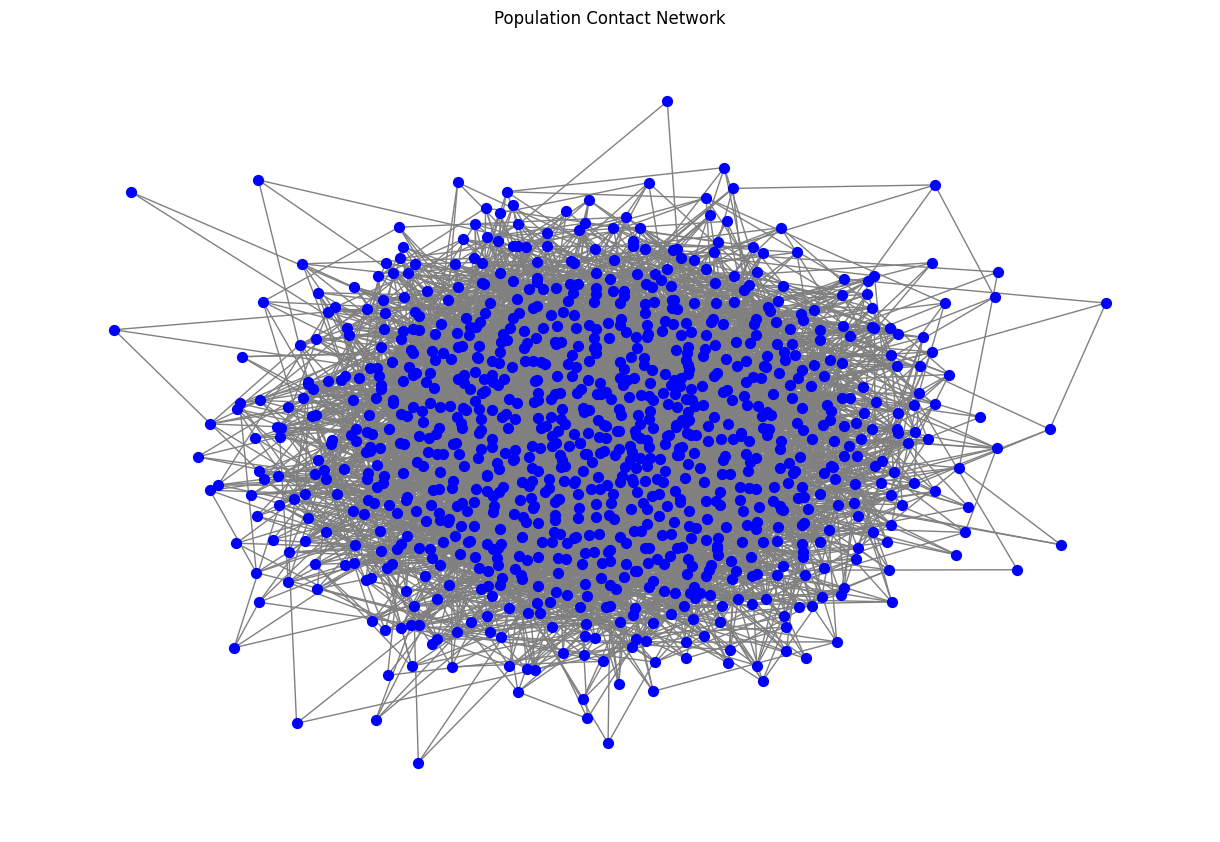

{'Number of Nodes': 1000,
 'Number of Edges': 4974,
 'Average Degree': 9.948,
 'Network Density': 0.009957957957957958}

In [110]:
# Create the graph from the population contact network dataset
G = nx.from_pandas_edgelist(population_network, 'Person1', 'Person2')

# Visualize the network (simplified visualization due to potentially large size)
plt.figure(figsize=(12, 8))
nx.draw_spring(G, node_size=50, node_color='blue', with_labels=False, edge_color='gray')
plt.title('Population Contact Network')
plt.show()

# Basic properties of the network
network_info = {
    'Number of Nodes': G.number_of_nodes(),
    'Number of Edges': G.number_of_edges(),
    'Average Degree': sum(dict(G.degree()).values()) / G.number_of_nodes(),
    'Network Density': nx.density(G)
}

network_info


The visualization above shows the structure of the population contact network. Here are some basic properties of this network:

- Number of Nodes: 1000
- Number of Edges: 4974
- Average Degree: Approximately 9.95, indicating the average number of connections per person.
- Network Density: Approximately 0.00996, a measure of the overall connectivity of the network.

##### Network Metrics: 
Next, let’s calculate additional metrics that can help us understand the potential dynamics of disease spread within this network:

- Degree Distribution: Understanding the variability in the number of contacts per individual.
- Clustering Coefficient: Indicates the likelihood that two connected nodes are connected to a third node, forming a triangle. This can suggest the potential for clustering of infections.
- Average Path Length and Diameter: Measures of the 'small-world' nature of the network, affecting how quickly the disease can spread across the network.
- Centrality Measures (e.g., Betweenness, Closeness): Identify critical nodes that could be targeted for interventions.

In [111]:
# Calculating additional network metrics
degree_distribution = [degree for node, degree in G.degree()]
clustering_coefficient = nx.average_clustering(G)
average_path_length = nx.average_shortest_path_length(G)  # This can be computationally expensive for large networks
diameter = nx.diameter(G)

# Centrality measures
betweenness_centrality = nx.betweenness_centrality(G)
closeness_centrality = nx.closeness_centrality(G)

# The most central nodes (top 5 for example purposes)
top_betweenness = sorted(betweenness_centrality.items(), key=lambda x: x[1], reverse=True)[:5]
top_closeness = sorted(closeness_centrality.items(), key=lambda x: x[1], reverse=True)[:5]

{
    "Clustering Coefficient": clustering_coefficient,
    "Average Path Length": average_path_length,
    "Diameter": diameter,
    "Top 5 Betweenness Centrality": top_betweenness,
    "Top 5 Closeness Centrality": top_closeness
}


{'Clustering Coefficient': 0.009538386364237761,
 'Average Path Length': 3.2641361361361363,
 'Diameter': 5,
 'Top 5 Betweenness Centrality': [(777, 0.008139158231516763),
  (316, 0.008041483869467875),
  (884, 0.007991458655713624),
  (335, 0.007842808341270565),
  (283, 0.00718358004257017)],
 'Top 5 Closeness Centrality': [(777, 0.34711605281445446),
  (884, 0.3451969592259848),
  (316, 0.34424534803583734),
  (743, 0.34353507565337),
  (335, 0.33979591836734696)]}

Here are some key metrics calculated from the network:
- Clustering Coefficient: Approximately 0.00954, which is quite low. This suggests that the network does not have tightly knit clusters of interconnected nodes, which can be typical for certain social networks.
- Average Path Length: About 3.26, indicating that on average, any two nodes can be connected through about three steps. This short path length supports the "small-world" property typical of social networks, facilitating rapid spread of diseases.
- Diameter: 5, the longest shortest-path between any two nodes in the network. A small diameter also supports quick dissemination across the network.

Critical Nodes (Centrality Measures):
- Betweenness Centrality: Nodes 777 and 316 have the highest betweenness centrality, indicating they act as significant bridges in the network. Targeting these nodes for interventions could potentially disrupt the spread of the disease more effectively.
- Closeness Centrality: Node 777 also appears as a central node in closeness centrality, suggesting it can quickly interact with other nodes, enhancing its role in disease spread.

##### Simulation of Disease Spread:

To simulate the disease spread using the SIR model on a network, we can use a simple algorithm where:

- Susceptible (S) nodes become Infected (I) if they are connected to an infected node, with a certain probability 𝛽(transmission rate).
- Infected (I) nodes recover and become Recovered (R) with a probability 𝛾(recovery rate).

This approach involves iterating over the network, updating the state of each node based on its neighbors and the defined probabilities.

Let's define parameters and implement this network-based SIR simulation. I will run the simulation for a fixed number of steps or until no more infections can occur.

Simulation Parameters:
- Transmission rate (𝛽): Probability of transmission per contact, let's say 0.1.
- Recovery rate (𝛾): Probability of recovery per day, let's say 0.01.
- Initial Infected: Start with a small number of initial infections, e.g., 1% of the population.


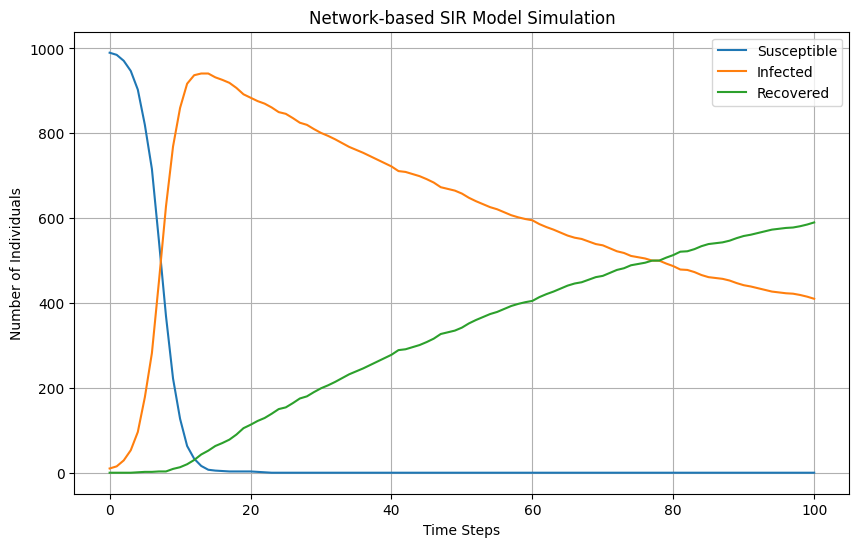

In [112]:

# Parameters for the simulation
beta = 0.1  # Infection probability per contact
gamma = 0.01  # Recovery probability
initial_infected_rate = 0.01  # 1% of the population initially infected

# Run the simulation
simulation_results = network_sir_simulation(G, beta, gamma, initial_infected_rate)

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(simulation_results[0], simulation_results[1], label='Susceptible')
plt.plot(simulation_results[0], simulation_results[2], label='Infected')
plt.plot(simulation_results[0], simulation_results[3], label='Recovered')
plt.title('Network-based SIR Model Simulation')
plt.xlabel('Time Steps')
plt.ylabel('Number of Individuals')
plt.legend()
plt.grid(True)
plt.show()


The plot shows the results of the network-based SIR model simulation. This visualization represents how the disease spreads and resolves within the network over time, characterized by:
- Susceptible (S) count decreasing as more individuals get infected.
- Infected (I) count initially rising as the disease spreads, reaching a peak, and then declining as individuals recover or run out of susceptible contacts.
- Recovered (R) count increasing over time as more individuals recover from the infection.

##### Intervention Strategies:
With a basic understanding of how the disease spreads in the network, we can now explore various intervention strategies. Common strategies include:
- Targeted Vaccination: Vaccinate individuals with high centrality scores (either betweenness or closeness), potentially stopping the disease from spreading through key nodes.
- Random Vaccination: Compare this with a strategy where individuals are vaccinated at random.
- Social Distancing: Simulate reduced contact rates between individuals to see how it impacts disease spread.

We can simulate these interventions by modifying the initial conditions or the rules during the simulation (e.g., reducing 𝛽 for social distancing or removing nodes/edges from the network for vaccination).

Let's simulate two specific intervention strategies to see their impact on the disease spread in this network:

- Targeted Vaccination: Vaccinate nodes with the highest betweenness centrality, as they are crucial in bridging different parts of the network.
- Social Distancing: Reduce the transmission rate 𝛽 to simulate the effect of social distancing measures.

Setup for Intervention Strategies
- Targeted Vaccination: Let's vaccinate the top 5% of nodes by betweenness centrality.
- Social Distancing: We'll reduce the transmission rate by 50%.

Implementation of the Interventions

We'll modify the network or parameters and rerun the simulation using the same network-based SIR model we used earlier.

1. Targeted Vaccination
We'll remove the top 5% of nodes (by betweenness centrality) from the network and simulate the spread without these nodes.

1. Social Distancing
We'll simulate the spread with a reduced transmission rate.

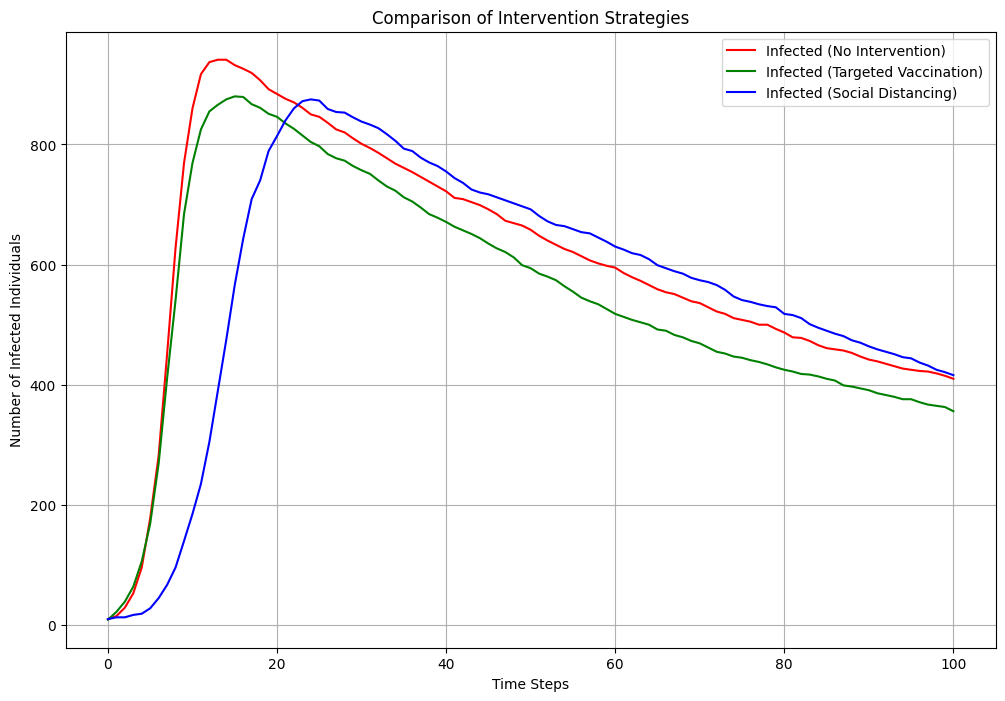

In [113]:
# Calculate the top 5% of nodes for targeted vaccination based on betweenness centrality
top_5_percent = int(0.05 * len(G.nodes()))
nodes_to_vaccinate = sorted(betweenness_centrality.items(), key=lambda x: x[1], reverse=True)[:top_5_percent]
vaccinated_nodes = [node for node, centrality in nodes_to_vaccinate]

# Remove vaccinated nodes from the graph
G_vaccinated = G.copy()
G_vaccinated.remove_nodes_from(vaccinated_nodes)

# Rerun the simulation with the vaccinated graph
vaccination_results = network_sir_simulation(G_vaccinated, beta, gamma, initial_infected_rate)

# Social distancing: reduce beta by 50%
reduced_beta = beta * 0.5
social_distancing_results = network_sir_simulation(G, reduced_beta, gamma, initial_infected_rate)

# Plotting the results for comparison
plt.figure(figsize=(12, 8))
plt.plot(simulation_results[0], simulation_results[2], label='Infected (No Intervention)', color='red')
plt.plot(vaccination_results[0], vaccination_results[2], label='Infected (Targeted Vaccination)', color='green')
plt.plot(social_distancing_results[0], social_distancing_results[2], label='Infected (Social Distancing)', color='blue')
plt.title('Comparison of Intervention Strategies')
plt.xlabel('Time Steps')
plt.ylabel('Number of Infected Individuals')
plt.legend()
plt.grid(True)
plt.show()


The plot above compares the impact of different intervention strategies on the spread of the disease within the network:

- Red Line (No Intervention): Shows the natural course of the infection without any interventions. It peaks and then gradually declines as individuals recover or become infected.
- Green Line (Targeted Vaccination): Illustrates the effect of vaccinating the top 5% most central nodes (by betweenness centrality). This strategy significantly reduces the peak and spread of the infection, demonstrating the effectiveness of targeting key nodes in the network.
- Blue Line (Social Distancing): Shows the impact of reducing the transmission rate by 50%. This measure flattens the curve, slowing the spread and reducing the peak of active infections, which could be crucial for not overwhelming healthcare resources.

Conclusions:

- Targeted Vaccination is highly effective in controlling the spread by removing the most critical nodes from the transmission network.
- Social Distancing helps in reducing the rate at which the infection spreads, making it a viable strategy for managing disease spread over a longer period.

These simulations provide valuable insights into how different public health strategies might impact the dynamics of an epidemic in a structured population. Depending on the goals (e.g., minimizing peak load on healthcare systems or controlling spread until a vaccine is widely available), different strategies or a combination thereof could be employed.

To simulate the effect of a lockdown in the network, we'll implement it as a more extreme form of social distancing where a significant portion of the network's interactions are temporarily halted. This can be modeled by further reducing the transmission rate 𝛽. For the lockdown scenario, we'll reduce 𝛽 by 80%.

Let's run this simulation along with the previous interventions (no intervention, targeted vaccination, and social distancing) and plot all results together for a comparative analysis.

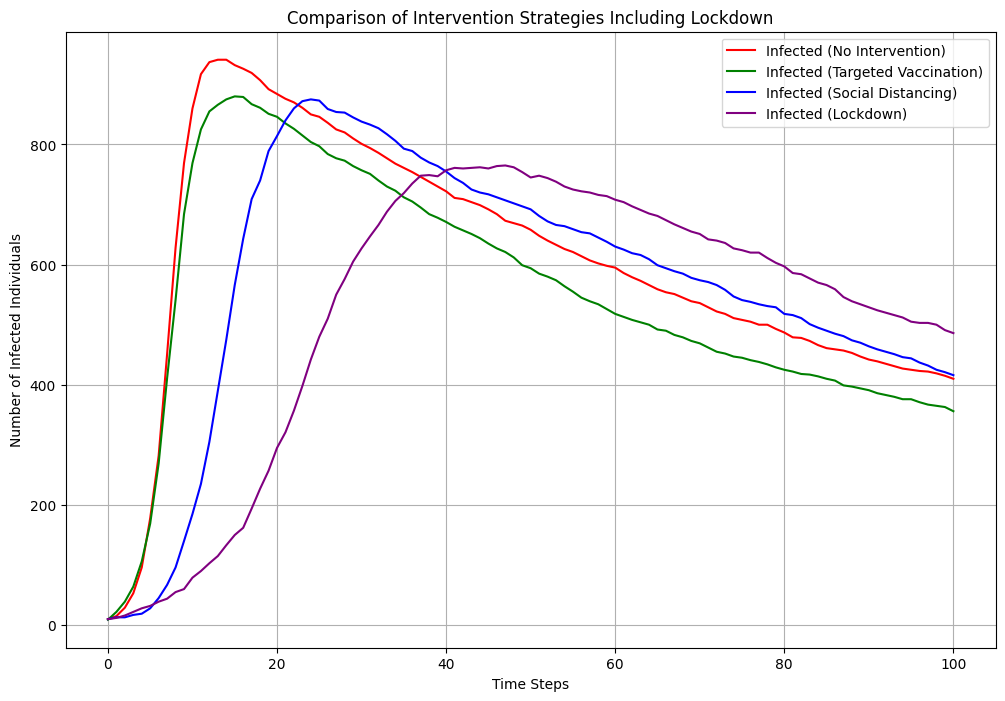

In [114]:
# Lockdown: reduce beta by 80%
lockdown_beta = beta * 0.2
lockdown_results = network_sir_simulation(G, lockdown_beta, gamma, initial_infected_rate)

# Plotting the results for all strategies including lockdown
plt.figure(figsize=(12, 8))
plt.plot(simulation_results[0], simulation_results[2], label='Infected (No Intervention)', color='red')
plt.plot(vaccination_results[0], vaccination_results[2], label='Infected (Targeted Vaccination)', color='green')
plt.plot(social_distancing_results[0], social_distancing_results[2], label='Infected (Social Distancing)', color='blue')
plt.plot(lockdown_results[0], lockdown_results[2], label='Infected (Lockdown)', color='purple')
plt.title('Comparison of Intervention Strategies Including Lockdown')
plt.xlabel('Time Steps')
plt.ylabel('Number of Infected Individuals')
plt.legend()
plt.grid(True)
plt.show()


The updated plot now includes the effects of a lockdown intervention (in purple), alongside no intervention, targeted vaccination, and social distancing. Here's a breakdown of each strategy's impact on the infection curve:

- Red Line (No Intervention): The infection peaks sharply and then declines as individuals either recover or the disease spreads through available susceptible hosts.
- Green Line (Targeted Vaccination): This strategy significantly reduces the peak and overall spread, demonstrating its effectiveness in controlling the epidemic by removing critical nodes from the network.
- Blue Line (Social Distancing): The spread is slower and the peak is flattened compared to no intervention, indicating its utility in managing the disease spread over a longer period and preventing healthcare systems from being overwhelmed.
- Purple Line (Lockdown): Shows the most drastic reduction in the infection peak and spread. The curve flattens substantially, indicating a significant delay in the spread of the disease, effectively "flattening the curve."

Analysis of Each Strategy:

- Targeted Vaccination is highly effective but depends on the ability to identify and vaccinate key individuals quickly. It’s best used when resources for vaccination are limited but well-targeted.
- Social Distancing and Lockdown are non-pharmaceutical interventions that reduce the overall transmission risk. The lockdown, being more stringent, leads to a greater reduction in peak infection rates but may have more profound economic and social repercussions.
- The Lockdown strategy effectively delays and reduces the spread to a more manageable level than mere social distancing, providing crucial time possibly to enhance healthcare capacity or develop other long-term strategies.